In [1]:
import jax
# Global flag to set a specific platform, must be used at startup.
#jax.config.update('jax_platform_name', 'cpu')


import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='False'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.80'

import gc

def clear_jax_caches():
  """Utility to clear all the function caches in jax."""
  # main jit/pmap lu wrapped function caches - have to grab from closures
  jax.xla._xla_callable.__closure__[1].cell_contents.clear()
  jax.pxla.parallel_callable.__closure__[1].cell_contents.clear()
  # primitive callable caches
  jax.xla.xla_primitive_callable.cache_clear()
  jax.xla.primitive_computation.cache_clear()
  # jaxpr caches for control flow and reductions
  jax.lax.lax_control_flow._initial_style_jaxpr.cache_clear()
  jax.lax.lax_control_flow._fori_body_fun.cache_clear()
  jax.lax.lax._reduction_jaxpr.cache_clear()
  # these are trivial and only included for completeness sake
  jax.lax.lax.broadcast_shapes.cache_clear()
  jax.xla.xb.get_backend.cache_clear()
  jax.xla.xb.dtype_to_etype.cache_clear()
  jax.xla.xb.supported_numpy_dtypes.cache_clear()
    
def reset_device_memory(delete_objs=True):
    """Free all tracked DeviceArray memory and delete objects.

  Args:
    delete_objs: bool: whether to delete all live DeviceValues or just free.

  Returns:
    number of DeviceArrays that were manually freed.
  """
    dvals = (x for x in gc.get_objects() if isinstance(x, jax.xla.DeviceArray))
    n_deleted = 0
    for dv in dvals:
    
        if not isinstance(dv, jax.xla.DeviceConstant):
            try: 
                dv._check_if_deleted()  # pylint: disable=protected-access
                dv.device_buffer.delete()
                n_deleted += 1
            except:
                pass
        if delete_objs:

            del dv
    del dvals
    gc.collect()
    return n_deleted

In [2]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from jax_unirep import get_reps
  
from jax_unirep import evotune, fit
from jax_unirep.utils import dump_params

In [5]:
#db_path="AMPS_NonAMPs.ready.csv"
db_path="../../datasets/newcluster/AMPs_NonAMPs.ready.nr70.csv"# <----- Change here AMPs_NonAMPs.ready.nr70.csv

In [6]:
AMPs_df=pd.read_csv(db_path,sep=',',header=0,quoting=csv.QUOTE_ALL)
AMPs_df # Class 0= AMPs , 1=NonAMps

,ID,Sequence,length,class
0,EN92515250|C|B3FJD7|phage,MAKKSVPLRKPAGSDGQGNIKVPGGPVVLDLGDFDDIFGPMESESP...,2337,0
1,EN54061055|C|F8SJ56|phage,MASKKTTLPKPKGINPQGSIVQLDLDDFDDLFDEDFGLPKKNSPYT...,2319,0
2,EN4815120|C|Q8SCY1|phage,MAKKVTLPKGQTGATGTTLGQAGNILDLSDVDDIFGDTPKAKKGSP...,2237,0
3,EN3016141|D|D2J8A7|bacteriocin,MAETIKGLRIDLSLKDMGVGRSITELKRSFRTLNSDLKVSSKNFEY...,1619,0
4,EN9175723|BD|Q93IM3|bacteriocin,MAKKKNTYKVPSIIALTLAGTALTTHHAQAADKTQDQSTNKNILND...,1564,0
...,...,...,...,...
15411,UniRef50_B4IRR3 GL21409 (Fragment) n=18 Tax=Dr...,IIHPLEDVSVTKGENAIFELELSKGDALVKWFKNGKELVFNDRVQL...,320,1
15412,UniRef50_A7RSM8 Predicted protein (Fragment) n...,MCCFAKKAAPALRCISPKNVFSNCDDLMKNKTLQVCIWILGLSALI...,321,1
15413,UniRef50_A0A0C9R2H6 PTPRE_0 protein n=4 Tax=Op...,MVDNRQQYLLAHLTLVECLLTLSTAMPCNETLPAKIQEQKRQLSQQ...,322,1
15414,UniRef50_V5I3N6 Uncharacterized protein (Fragm...,LYTGKFGKELLGMDTLHKMVWVKLMARMFEAMAGFFAHSSDIHLFL...,323,1


In [7]:
_h_avg, h_final, c_final= get_reps(AMPs_df['Sequence'].to_list())
AMPs_df['reps']=_h_avg.tolist()
AMPs_df.to_pickle('AMPsNonAMPs_df.plk')
AMPs_df

,ID,Sequence,length,class,reps
0,EN92515250|C|B3FJD7|phage 201phi2-1 lysin,MAKKSVPLRKPAGSDGQGNIKVPGGPVVLDLGDFDDIFGPMESESP...,2337,0,"[0.0032203220762312412, 0.07328620553016663, 0..."
1,EN54061055|C|F8SJ56|phage PhiPA3 lysin,MASKKTTLPKPKGINPQGSIVQLDLDDFDDLFDEDFGLPKKNSPYT...,2319,0,"[0.0027930964715778828, 0.06916013360023499, 0..."
2,EN4815120|C|Q8SCY1|phage phiKZ lysin,MAKKVTLPKGQTGATGTTLGQAGNILDLSDVDDIFGDTPKAKKGSP...,2237,0,"[0.0023172732908278704, 0.05406315624713898, 0..."
3,EN3016141|D|D2J8A7|bacteriocin,MAETIKGLRIDLSLKDMGVGRSITELKRSFRTLNSDLKVSSKNFEY...,1619,0,"[0.014644640497863293, 0.07187927514314651, 0...."
4,EN9175723|BD|Q93IM3|bacteriocin,MAKKKNTYKVPSIIALTLAGTALTTHHAQAADKTQDQSTNKNILND...,1564,0,"[0.0062357354909181595, 0.01848522014915943, 0..."
...,...,...,...,...,...
42440,UniRef50_A0A151HEL5 Zinc finger C3HC4 type (R...,GLYFRPRRRASS,12,1,"[0.0483490452170372, -0.007824046537280083, -0..."
42441,UniRef50_K2MU79 Retrotransposon hot spot (RHS)...,MESNPMTLVGCG,12,1,"[0.047337695956230164, -0.013988062739372253, ..."
42442,UniRef50_A0A1E1IUT2 Flagellar calcium-binding ...,IRCVGHWMQAEH,12,1,"[0.04697670415043831, -0.027571065351366997, -..."
42443,UniRef50_A0A0S4ITT4 Dopa decarboxylase putati...,APWSASTLHCPG,12,1,"[0.04749748483300209, 0.005815288983285427, -0..."


In [84]:
AMPs_df = pd.read_pickle('/home/kongkitimanonk/SCRATCH_NOBAK/datasets/phase2/AMPsNonAMPs_df.plk')
AMPs_df

,ID,Sequence,length,class,reps
0,EN92515250|C|B3FJD7|phage 201phi2-1 lysin,MAKKSVPLRKPAGSDGQGNIKVPGGPVVLDLGDFDDIFGPMESESP...,2337,0,"[0.0032203220762312412, 0.07328620553016663, 0..."
1,EN54061055|C|F8SJ56|phage PhiPA3 lysin,MASKKTTLPKPKGINPQGSIVQLDLDDFDDLFDEDFGLPKKNSPYT...,2319,0,"[0.0027930964715778828, 0.06916013360023499, 0..."
2,EN4815120|C|Q8SCY1|phage phiKZ lysin,MAKKVTLPKGQTGATGTTLGQAGNILDLSDVDDIFGDTPKAKKGSP...,2237,0,"[0.0023172732908278704, 0.05406315624713898, 0..."
3,EN3016141|D|D2J8A7|bacteriocin,MAETIKGLRIDLSLKDMGVGRSITELKRSFRTLNSDLKVSSKNFEY...,1619,0,"[0.014644640497863293, 0.07187927514314651, 0...."
4,EN9175723|BD|Q93IM3|bacteriocin,MAKKKNTYKVPSIIALTLAGTALTTHHAQAADKTQDQSTNKNILND...,1564,0,"[0.0062357354909181595, 0.01848522014915943, 0..."
...,...,...,...,...,...
42440,UniRef50_A0A151HEL5 Zinc finger C3HC4 type (R...,GLYFRPRRRASS,12,1,"[0.0483490452170372, -0.007824046537280083, -0..."
42441,UniRef50_K2MU79 Retrotransposon hot spot (RHS)...,MESNPMTLVGCG,12,1,"[0.047337695956230164, -0.013988062739372253, ..."
42442,UniRef50_A0A1E1IUT2 Flagellar calcium-binding ...,IRCVGHWMQAEH,12,1,"[0.04697670415043831, -0.027571065351366997, -..."
42443,UniRef50_A0A0S4ITT4 Dopa decarboxylase putati...,APWSASTLHCPG,12,1,"[0.04749748483300209, 0.005815288983285427, -0..."


Remove Duplicate

In [100]:
AMPs_df.drop_duplicates(subset=['Sequence'],inplace=True)
AMPs_df

,ID,Sequence,length,class,reps
0,EN92515250|C|B3FJD7|phage 201phi2-1 lysin,MAKKSVPLRKPAGSDGQGNIKVPGGPVVLDLGDFDDIFGPMESESP...,2337,0,"[0.0032203220762312412, 0.07328620553016663, 0..."
1,EN54061055|C|F8SJ56|phage PhiPA3 lysin,MASKKTTLPKPKGINPQGSIVQLDLDDFDDLFDEDFGLPKKNSPYT...,2319,0,"[0.0027930964715778828, 0.06916013360023499, 0..."
2,EN4815120|C|Q8SCY1|phage phiKZ lysin,MAKKVTLPKGQTGATGTTLGQAGNILDLSDVDDIFGDTPKAKKGSP...,2237,0,"[0.0023172732908278704, 0.05406315624713898, 0..."
3,EN3016141|D|D2J8A7|bacteriocin,MAETIKGLRIDLSLKDMGVGRSITELKRSFRTLNSDLKVSSKNFEY...,1619,0,"[0.014644640497863293, 0.07187927514314651, 0...."
4,EN9175723|BD|Q93IM3|bacteriocin,MAKKKNTYKVPSIIALTLAGTALTTHHAQAADKTQDQSTNKNILND...,1564,0,"[0.0062357354909181595, 0.01848522014915943, 0..."
...,...,...,...,...,...
42439,UniRef50_B2ABU5 Podospora anserina S mat+ geno...,MKWKAIIAAYGM,12,1,"[0.04739842936396599, 0.01943567767739296, -0...."
42440,UniRef50_A0A151HEL5 Zinc finger C3HC4 type (R...,GLYFRPRRRASS,12,1,"[0.0483490452170372, -0.007824046537280083, -0..."
42441,UniRef50_K2MU79 Retrotransposon hot spot (RHS)...,MESNPMTLVGCG,12,1,"[0.047337695956230164, -0.013988062739372253, ..."
42442,UniRef50_A0A1E1IUT2 Flagellar calcium-binding ...,IRCVGHWMQAEH,12,1,"[0.04697670415043831, -0.027571065351366997, -..."


## Split train and test set

In [91]:
# Test whether to_list and to_numpy affect the ML performance 
# Results differ whether using a list or a numpy array in scikit-learn
#X= AMPs_df['reps'].to_list() # return array of list
#y= AMPs_df['class'].to_list()
#X= AMPs_df['reps'].values # return array of list
#y= AMPs_df['class'].values

In [92]:
print (len(X[0]))

1900


In [101]:
X= np.array(AMPs_df['reps'].to_list())
y= np.array(AMPs_df['class'].to_list())

In [102]:
X.shape

(41951, 1900)

In [103]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [104]:
# X_train y_train
# X_val y_val
# X_test y_test
X_train[0]

array([ 0.02685761, -0.03271403, -0.00748357, ...,  0.0574573 ,
        0.13910499,  0.04347068])

Use jax-unirep to get "reps" of our sequences

In [11]:
#encoded_XTest_h_avg, h_final, c_final= get_reps(X_test.to_list())


In [17]:
#encoded_XTest_h_avg

array([[ 4.50811908e-02, -5.70504107e-02, -3.91879268e-02, ...,
        -8.85980297e-03,  5.41265979e-02,  6.03123158e-02],
       [ 3.57009210e-02, -3.04098334e-02, -5.79583272e-03, ...,
         6.09648451e-02,  5.16050644e-02,  3.03401612e-02],
       [ 3.95193771e-02, -4.01638374e-02, -2.71999035e-02, ...,
         6.24471903e-02,  6.75325021e-02,  8.85927826e-02],
       ...,
       [ 1.58738364e-02, -2.10723922e-01,  2.83727273e-02, ...,
        -1.26511147e-02,  2.57162124e-01,  3.57268602e-02],
       [ 6.42440375e-03, -2.62509752e-02,  9.60013786e-05, ...,
        -3.68243158e-02,  4.33110595e-02, -6.82816878e-02],
       [ 1.23925926e-02, -5.59971184e-02,  1.00520616e-02, ...,
         5.38413972e-03,  7.47785345e-02,  1.19894199e-01]])

In [9]:
#encoded_XTrain_h_avg, h_final, c_final= get_reps(X_train.to_list())

# Implement Toy Model (RF)

In [105]:
from sklearn.ensemble import RandomForestClassifier 

classifier = RandomForestClassifier (n_estimators=20, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [106]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      4264
           1       0.91      0.88      0.89      4127

    accuracy                           0.90      8391
   macro avg       0.90      0.90      0.90      8391
weighted avg       0.90      0.90      0.90      8391

0.8964366583243952


[[3888  376]
 [ 493 3634]]


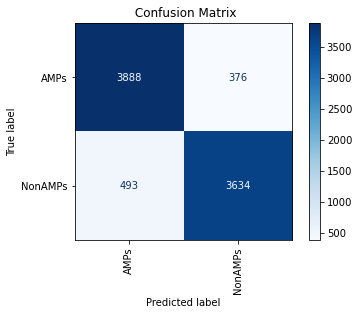

In [107]:
from sklearn.metrics import plot_confusion_matrix

class_names = ['AMPs', 'NonAMPs']

disp = plot_confusion_matrix(classifier, X_test, y_test,
                            display_labels = class_names,
                            cmap=plt.cm.Blues, xticks_rotation='vertical')

disp.ax_.set_title(" Confusion Matrix")

print(disp.confusion_matrix)
plt.grid(False)
plt.show()

In [15]:
#import scikitplot as skplt
#skplt.metrics.plot_roc([], y_pred)

In [ ]:
y_pred

In [ ]:
y_test.to_numpy()

# Custom Build

In [ ]:
## 1. Evotuning with Optuna
PROJECT_NAME = "temp"
n_epochs_config = {"low": 1, "high": 1}
lr_config = {"low": 1e-5, "high": 1e-3}
study, evotuned_params = evotune(
    sequences=X_test,
    params=None,
    proj_name=PROJECT_NAME,
    out_dom_seqs=X_val,
    n_trials=2,
    n_splits=2,
    n_epochs_config=n_epochs_config,
    learning_rate_config=lr_config,
    epochs_per_print=1,
)

dump_params(evotuned_params, PROJECT_NAME)
print("Evotuning done! Find output weights in", PROJECT_NAME)
print(study.trials_dataframe())


In [ ]:
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, Sigmoid

from jax_unirep.layers import mLSTM1900, mLSTM1900_AvgHidden

init_fun, apply_fun = stax.serial(
    mLSTM1900(),
    mLSTM1900_AvgHidden(),
    # Add two layers, one dense layer that results in 512-dim activations
    Dense(512), Relu(),
    # And then a linear layer to produce a 1-dim activation
    Dense(1)
)